In [10]:
import pandas as pd
from itertools import product
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import numpy as np

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import copy

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

In [67]:
class DataFinal():
    def __init__(self):
        self.original = pd.read_csv('../html2023-spring-final-project/train.csv')
        self.orginDataset = self.original.copy()
        self.get_labels()
        data = self.dataPreprocessing(self.original)
        self.createEncodeDataTraining(data)
        self.splitDataset()

        self.originalTest = pd.read_csv('../html2023-spring-final-project/test.csv')
        datatest = self.dataPreprocessing(self.originalTest)
        self.createEncodeDataTesting(datatest) 
        self.testDatasetFile()  

      

    def get_labels(self):
        self.labels = self.original['Danceability']
        self.original.drop(['Danceability'], axis=1, inplace=True) 

    def fillOptions(self, data, option = 'max'):
        if data.isna().sum() != len(data):
            if option == 'max':
                return data.value_counts().idxmax()
            elif option == 'mean':
                return data.mean()
            elif option == 'median':
                return data.median()
            



    def filterArtistComposerDance(self, data, nameColumnFill):

        listArtist = data['Artist'].unique()
        listComposer = data['Composer'].unique()
    
        filter = list(product(listArtist, listComposer))

        newData = pd.DataFrame(columns=data.columns)

        for i in filter:
            artist, composer = i[0], i[1]
            filterData = data[(data['Artist'] == artist) & (data['Composer'] == composer) ].copy()
            if len(filterData) != 0:
            # Fill column Name
                for nameColumn in nameColumnFill:
                    fillInfo = self.fillOptions(filterData[nameColumn], option = 'max')
                    if fillInfo != None:
                        filterData.loc[:,nameColumn].fillna(fillInfo, inplace=True)

                newData = pd.concat([newData, filterData], ignore_index=True)
        return newData
    
    def filterArtist(self, data, nameColumnFill):
        listDance = data['Artist'].unique()
        filter = listDance


        newData = pd.DataFrame(columns=data.columns)

        for i in filter:
            dance = i
            filterData = data[ (data['Artist'] == dance)].copy()
    
    
            if len(filterData) != 0:
                # Fill column Name
                for nameColumn in nameColumnFill:
                    fillInfo = self.fillOptions(filterData[nameColumn], option = 'max')
                    if fillInfo != None:
                        filterData.loc[:,nameColumn].fillna(fillInfo, inplace=True)

                newData = pd.concat([newData, filterData], ignore_index=True)

        return newData
    
    def filterFillData(self, data, nameColumnFill):
        if not data.isnull().any().any():
            return data
        else:
            for nameColumn in nameColumnFill:
                fillInfo = self.fillOptions(data[nameColumn], option = 'max')
                if fillInfo != None:
                    data.loc[:,nameColumn].fillna(fillInfo, inplace=True)
        return data
    
    def dataPreprocessing(self, original):
    
        # pd.options.mode.chained_assignment = None

        data = original.copy()

        nameColumnFill = ['Energy', 'Key', 'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Duration_ms', 'Duration_ms', 'Views', 'Likes', "Stream" , "Comments"]

        # License and official_video
        data['Licensed'].fillna(data['official_video'], inplace=True)
        data['Licensed'].fillna(False, inplace=True)

        data['official_video'].fillna(data['Licensed'], inplace=True)
        data['official_video'].fillna(False, inplace=True)

        data['official_video'].fillna(False, inplace=True)
        data['Licensed'].fillna(False, inplace=True)

        data['Licensed'] =  data['Licensed'].map({True: 1, False: 0})
        data['official_video'] = data['official_video'].map({True: 1, False: 0})
    
        # Create new class = 'Unknown'
        data['Composer'].fillna("Unknown", inplace=True)
        data['Artist'].fillna("Unknown", inplace=True)
        data['Album_type'].fillna("Unknown", inplace=True)

        newData = self.filterArtistComposerDance(data, nameColumnFill)
        data = newData.copy()

        newData = self.filterArtist(data, nameColumnFill)
        data = newData.copy()

        newData = self.filterFillData(data, nameColumnFill)
        data = newData.copy()

        #Transform type key to use as class
        data['Key'] = data['Key'].astype(int)
        data['Key'] = data['Key'].astype(str)

        data = data.sort_values('id')

        # DELETE Track, Album, Uri, Url_spotify, Url_youtube, Description, Title, Channel, id, Comments
        data.drop(['Track', 'Album', 'Uri', 'Url_spotify', 'Url_youtube', 'Description', 'Title', 'Channel', 'id'], axis=1, inplace=True)

        # pd.options.mode.chained_assignment = 'warn'

        return data
    
    def convertEncoderPD(self, data, prefix = 'key'):
        titleKeys = []
        for i in range(data.shape[1]):
            titleKeys.append(f'{prefix}_{i}')
    
        return pd.DataFrame(data=data, columns= titleKeys)
    
    # minX -60  maxX = 0  ~ 0 - 1
    # y = (-1/60) x
    def scaleMinMaxLoudness(self, data):
        return -data/60
    
    def createEncodeDataTraining(self, data):

        encoderKey = OneHotEncoder()
        encodedKey = encoderKey.fit_transform(data[['Key']])
        Key = encodedKey.toarray()
        key_pd = self.convertEncoderPD(Key, prefix = 'key')

        encoderAlbumType = OneHotEncoder()
        encodedKeyAlbumType = encoderAlbumType.fit_transform(data[['Album_type']])
        AlbumType = encodedKeyAlbumType.toarray()
        AlbumType_pd = self.convertEncoderPD(AlbumType, prefix = 'AlbumType')

        encoderComposer = OneHotEncoder()
        encodedKeyComposer = encoderComposer.fit_transform(data[['Composer']])
        Composer = encodedKeyComposer.toarray()
        Composer_pd = self.convertEncoderPD(Composer, prefix = 'Composer')

        encoderArtist = OneHotEncoder()
        encodedArtist = encoderArtist.fit_transform(data[['Artist']])
        Artist =  encodedArtist.toarray()
        Artist_pd = self.convertEncoderPD(Artist, prefix = 'Artist')

        # encoderArtist = LabelEncoder()
        # encodedArtist = encoderArtist.fit_transform(data[['Artist']])
        # # encodedArtist = encodedArtist.ravel()
        # Artist_pd =  pd.DataFrame(data=encodedArtist, columns= ["Artist"])

        data.drop(['Key','Album_type', 'Composer',  'Artist'], axis=1, inplace=True)

        data = pd.concat([data, key_pd, AlbumType_pd, Composer_pd, Artist_pd], axis=1)

        scaledLoudness = self.scaleMinMaxLoudness(data[['Loudness']])
        data['Loudness'] = scaledLoudness

        newMinMaxScaler = ['Tempo', 'Duration_ms', 'Views', 'Likes', 'Stream', 'Comments']

        scaler = MinMaxScaler()
        scaledData = scaler.fit_transform(data[newMinMaxScaler])

        for i in range(scaledData.shape[1]):
            data[newMinMaxScaler[i]] = scaledData[:, i]


        self.dataEncoders = {"key": encoderKey, 'AlbumType': encoderAlbumType, 'Composer': encoderComposer, "Artist":encoderArtist}
        self.stdScaler = scaler
        self.data = data

    def createEncodeDataTesting(self, data):

        encoderKey = self.dataEncoders['key']
        encodedKey = encoderKey.transform(data[['Key']])
        Key = encodedKey.toarray()
        key_pd = self.convertEncoderPD(Key, prefix = 'key')

        encoderAlbumType = self.dataEncoders['AlbumType']
        encodedKeyAlbumType = encoderAlbumType.transform(data[['Album_type']])
        AlbumType = encodedKeyAlbumType.toarray()
        AlbumType_pd = self.convertEncoderPD(AlbumType, prefix = 'AlbumType')

        encoderComposer = self.dataEncoders['Composer']
        encodedKeyComposer = encoderComposer.transform(data[['Composer']])
        Composer = encodedKeyComposer.toarray()
        Composer_pd = self.convertEncoderPD(Composer, prefix = 'Composer')  

        encoderArtist = self.dataEncoders['Artist']
        encodedArtist = encoderArtist.fit_transform(data[['Artist']])
        Artist =  encodedArtist.toarray()
        Artist_pd = self.convertEncoderPD(Artist, prefix = 'Artist') 

        # encoderArtist = self.dataEncoders['Artist']
        # encodedArtist = encoderArtist.transform(data[['Artist']])
        # encodedArtist = encodedArtist.ravel()
        # Artist_pd =  pd.DataFrame(data=encodedArtist, columns= ["Artist"])

        data.drop(['Key','Album_type', 'Composer',  'Artist'], axis=1, inplace=True)

        data = pd.concat([data, key_pd, AlbumType_pd, Composer_pd, Artist_pd], axis=1)

        scaledLoudness = self.scaleMinMaxLoudness(data[['Loudness']])
        data['Loudness'] = scaledLoudness

        newMinMaxScaler = ['Tempo', 'Duration_ms', 'Views', 'Likes', 'Stream', 'Comments']

        scaler = self.stdScaler
        scaledData = scaler.transform(data[newMinMaxScaler])

        for i in range(scaledData.shape[1]):
            data[newMinMaxScaler[i]] = scaledData[:, i]

        self.dataTestFileLabels =  np.zeros((len(data),1))
        self.dataTestFile =  data

    def dataBlocksGenerator(self, data):
        musicMarket = pd.concat([data['Energy'], data['Valence'], data['Tempo'], data.iloc[:, 8:15]], axis=1)
        musicStats = pd.concat([data.iloc[:, 0:8], data.loc[:, data.columns.str.startswith("key")]], axis=1)       
        musicArtistComposer = pd.concat([data['Energy'], data['Valence'], data['Tempo'], data.loc[:, data.columns.str.startswith("key")], data.loc[:, data.columns.str.startswith("Artist")], data.loc[:, data.columns.str.startswith("Composer")], data.loc[:, data.columns.str.startswith("AlbumType")]], axis=1)

        return musicMarket, musicStats, musicArtistComposer 

    class DataPreparation(Dataset):
        def __init__(
                self, 
                musicMarket, 
                musicStats, 
                musicArtistComposer, 
                labels):
            
            self.musicMarket = torch.from_numpy(np.asarray(musicMarket).astype(np.float32)).to(torch.float32)
            self.musicStats = torch.from_numpy(np.asarray(musicStats).astype(np.float32)).to(torch.float32)
            self.musicArtistComposer = torch.from_numpy(np.asarray(musicArtistComposer).astype(np.float32)).to(torch.float32)
            self.labels = torch.from_numpy(np.asarray(labels, dtype=np.float32).reshape(labels.shape[0], 1)).to(torch.float32)
            
            self.n_samples = labels.shape[0]

        def __getitem__(self, index):
            return self.musicMarket[index], \
            self.musicStats[index], \
            self.musicArtistComposer[index], \
            self.labels[index]
        
        def __len__(self):
            return self.n_samples

    def splitDataset(self):
        train_X, test_X, train_Y, test_Y = train_test_split(self.data, self.labels, test_size = 0.20, random_state = 123)
        train_X, Validation_X, train_Y, Validation_Y = train_test_split(train_X, train_Y, test_size = 0.20, random_state = 123)

        train_musicMarket, train_musicStats, train_musicArtistComposer = self.dataBlocksGenerator(train_X)
        Validation_musicMarket, Validation_musicStats, Validation_musicArtistComposer = self.dataBlocksGenerator(Validation_X)
        test_musicMarket, test_musicStats, test_musicArtistComposer = self.dataBlocksGenerator(test_X)
        
        self.train = self.DataPreparation(train_musicMarket, train_musicStats, train_musicArtistComposer, train_Y)
        self.validate = self.DataPreparation(Validation_musicMarket, Validation_musicStats, Validation_musicArtistComposer, Validation_Y)
        self.test = self.DataPreparation(test_musicMarket, test_musicStats, test_musicArtistComposer, test_Y)

    def testDatasetFile(self):
       test_musicMarket, test_musicStats, test_musicArtistComposer = self.dataBlocksGenerator(self.dataTestFile) 
       self.testDATAFILE = self.DataPreparation(test_musicMarket, test_musicStats, test_musicArtistComposer, self.dataTestFileLabels)

        



In [20]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        musicMarket = 10
        musicStats = 19
        musicArtistComposer = 126

        out_musicMarket = 4
        out_musicStats = 8
        out_musicArtistComposer = 32

        concat = out_musicMarket + out_musicStats + out_musicArtistComposer
        
        # music Market
        self.mMl1 = nn.Linear(musicMarket, 8)
        self.mMact1 = nn.ReLU()
        self.mMd1 = nn.Dropout(p=0.2)

        self.mMl2 = nn.Linear(8, 6)
        self.mMact2 = nn.ReLU()
        self.mMd2 = nn.Dropout(p=0.2)

        self.mMl3 = nn.Linear(6, out_musicMarket)
        self.mMact3 = nn.ReLU()
        self.mMd3 = nn.Dropout(p=0.2)

        # music Stats
        self.mSl1 = nn.Linear(musicStats, 16)
        self.mSact1 = nn.ReLU()
        self.mSd1 = nn.Dropout(p=0.2) 

        self.mSl3 = nn.Linear(16, 12)
        self.mSact3 = nn.ReLU()
        self.mSd3 = nn.Dropout(p=0.2)

        self.mSl5 = nn.Linear(12, out_musicStats)
        self.mSact5 = nn.ReLU()
        self.mSd5 = nn.Dropout(p=0.2)

        # music musicArtistComposer
        self.mAl1 = nn.Linear(musicArtistComposer, 96)
        self.mAact1 = nn.ReLU()
        self.mAd1 = nn.Dropout(p=0.2) 

        self.mAl2 = nn.Linear(96, 64)
        self.mAact2 = nn.ReLU()
        self.mAd2 = nn.Dropout(p=0.2) 

        self.mAl3 = nn.Linear(64, out_musicArtistComposer)
        self.mAact3 = nn.ReLU()
        self.mAd3 = nn.Dropout(p=0.2) 

        # Concatenation
        self.cCl1 = nn.Linear(concat, 36)
        self.cCact1 = nn.ReLU()
        self.cCd1 = nn.Dropout(p=0.2) 

        self.cCl2 = nn.Linear(36, 16)
        self.cCact2 = nn.ReLU()
        self.cCd2 = nn.Dropout(p=0.2) 

        self.cCl3 = nn.Linear(16, 4)
        self.cCact3 = nn.ReLU()
        self.cCd3 = nn.Dropout(p=0.2) 

        self.cCl4 = nn.Linear(4, 1)
        self.out = nn.ReLU()
        # self.out = nn.Softmax(dim=1)
    
    def forward(self, musicMarket, musicStats, musicArtistComposer):
        # music Market
        outmM = self.mMl1(musicMarket)
        outmM = self.mMact1(outmM)
        outmM = self.mMd1(outmM)

        outmM = self.mMl2(outmM)
        outmM = self.mMact2(outmM)
        outmM = self.mMd2(outmM)

        outmM = self.mMl3(outmM)
        outmM = self.mMact3(outmM)
        outmM = self.mMd3(outmM)

        # music Stats   
        outmS = self.mSl1(musicStats)
        outmS = self.mSact1(outmS)
        outmS = self.mSd1(outmS) 

        outmS = self.mSl3(outmS)
        outmS = self.mSact3(outmS)
        outmS = self.mSd3(outmS)

        outmS = self.mSl5(outmS)
        outmS = self.mSact5(outmS)
        outmS = self.mSd5(outmS)

        # music musicArtistComposer
        outmA = self.mAl1(musicArtistComposer)
        outmA = self.mAact1(outmA)
        outmA = self.mAd1(outmA)

        outmA = self.mAl2(outmA)
        outmA = self.mAact2(outmA)
        outmA = self.mAd2(outmA) 

        outmA = self.mAl3(outmA)
        outmA = self.mAact3(outmA)
        outmA = self.mAd3(outmA) 

        concat = torch.cat((outmM, outmS, outmA), 1)

        # Concatenation
        out = self.cCl1(concat)
        out = self.cCact1(out)
        out = self.cCd1(out) 

        out = self.cCl2(out)
        out = self.cCact2(out)
        out = self.cCd2(out) 

        out = self.cCl3(out)
        out = self.cCact3(out)
        out = self.cCd3(out) 

        out = self.cCl4(out)
        return out # self.out(out)

In [6]:
class DLModel():
    def __init__(self, train, test, validate, learning_rate=1e-6, epoch = 10, batch_size = 16, device = 'cpu', loadModelFlag = False, loadModelFile = ''):
        self.lr = learning_rate
        self.epoch = epoch
        self.batch_size = batch_size
        self.device = self.getDevice(device)

        self.train = DataLoader(dataset = train, batch_size = self.batch_size, shuffle = True)
        self.validation = DataLoader(dataset = validate, batch_size = self.batch_size, shuffle = False)
        self.test = DataLoader(dataset = test, batch_size = self.batch_size, shuffle = False)

        
        
        self.model = self.loadModel(loadModelFlag = loadModelFlag, loadModelFile = loadModelFile)
        # Define the loss function
        self.criterion = nn.MSELoss()
        # self.criterion = nn.CrossEntropyLoss()
        # Create an SGD optimizer with L1 regularization
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr, weight_decay=0.001)

    def loadModel(self, loadModelFlag = False, loadModelFile = ''):
        if loadModelFlag:
            if loadModelFile != '':
                return torch.load(loadModelFile).to(self.device)
        return Model().to(self.device)
    
    def getDevice(self, device):
        if device != 'cpu':
            is_cuda =  torch.cuda.is_available()
            if is_cuda:
                return torch.device('cuda')
            return torch.device('cpu')
        return torch.device('cpu')
    
    def metric(self, y, y_hat):
        return np.mean(np.abs(y_hat - y))

    def trainModel(self, process_factor=2, patiente = 2, show_process = False, earlyStopFlag=True):
        self.lossTraining = []
        self.accTraining = []
        self.lossValidation = []
        self.accValidation  = []

        patiente_acum = 0  # patiente counter

        prev_metric = float('inf')  # best loss from validation
        best_Model =  copy.deepcopy(self.model.state_dict()) # best model
        self.best_epoch = 0

        process = tqdm(range(self.epoch),  desc = 'Epoch ===> ')
        for epoch in process:
            y_hat = []
            y = []
            flag = True

            loss_train = 0.0
            acc_train  = 0.0

            self.model.train()
            for idx, (musicMarket, musicStats, musicArtistComposer, labels) in enumerate(self.train):
                musicMarket = musicMarket.to(self.device)
                musicStats = musicStats.to(self.device)
                musicArtistComposer = musicArtistComposer.to(self.device)
                labels = labels.to(self.device)

                # forward
                outputs = self.model(musicMarket, musicStats, musicArtistComposer)
                loss = self.criterion(outputs, labels)
            
                # backward
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()


                '''
                    ---------------  Get predicted to calculate accuracy ----------------
                '''
                predicted = outputs.cpu().detach().numpy()
                ground_truth = labels.cpu().detach().numpy()

                if flag:
                    y_hat = predicted
                    y = ground_truth
                    flag = False

                y_hat = np.append(y_hat, predicted)
                y = np.append(y, ground_truth)

                acc = self.metric(y, y_hat)

                if show_process:
                    if (idx + 1) % process_factor== 0:
                        text = f'Training Stage ==> Epoch: {epoch} / {self.epoch - 1} | Step: {idx} / {len(self.train)} | Training loss: {loss.item():.5f} |  Training Evaluation Metric (MAE): {acc:.5f}'
                        print(text)

                loss_train = loss.item()
                acc_train = acc

                process.set_postfix({'Epoch':epoch,
                    'training_loss': loss_train, 
                    'training Acc': acc_train, 
                    'Step': idx,
                    'from': len(self.train)
                    })
            
            self.lossTraining.append(loss_train)
            self.accTraining.append(acc_train)
            metric = self.metric(y, y_hat)

            text = f'Training Stage ==> Epoch: {epoch} / {self.epoch - 1} | Training loss: {loss_train:.5f} |  Training Accuracy: {acc:.5f} | Training Metric (MAE): {metric:.5f}'
            print(text)
                


            ''' 
            ----------------------------------  EVALUATION STAGE  ---------------------------------------
                
            '''
            y_hat = []
            y = []
            flag = True

            loss_val = 0.0
            acc_val  = 0.0
      
      
            self.model.eval()
            with torch.no_grad():
                for idx, (musicMarket, musicStats, musicArtistComposer, labels) in enumerate(self.validation):
                    musicMarket = musicMarket.to(self.device)
                    musicStats = musicStats.to(self.device)
                    musicArtistComposer = musicArtistComposer.to(self.device)
                    labels = labels.to(self.device)

                    '''
                    ---------------   Forward    --------------------
                    '''

                    outputs = self.model(musicMarket, musicStats, musicArtistComposer)
                    loss = self.criterion(outputs, labels)


                    predicted = outputs.cpu().detach().numpy()
                    ground_truth = labels.cpu().detach().numpy()

                    if flag:
                        y_hat = predicted
                        y = ground_truth
                        flag = False

                    y_hat = np.append(y_hat, predicted)
                    y = np.append(y, ground_truth)

                    acc = self.metric(y, y_hat)

                    if show_process:
                        if (idx + 1) % process_factor== 0:
                            text = f'Validation Stage ==> Epoch: {epoch} / {self.epoch - 1} | Step: {idx} / {len(self.validation)} | Validation loss: {loss.item():.5f} |  Validation Evaluation Metric (MAE): {acc:.5f}'
                            print(text)

                    loss_val = loss.item()
                    acc_val = acc
                    process.set_postfix({'Epoch':epoch,
                    'validation_loss': loss_val, 
                    'Validation Acc': acc_val, 
                    'Step': idx,
                    'from': len(self.validation)
                    })
            
                self.lossValidation.append(loss_val)
                self.accValidation.append(acc_val)
                metric = self.metric(y, y_hat)
                text = f'Validation Stage ==> Epoch: {epoch} / {self.epoch - 1} | Validation loss: {loss_val:.5f} |  Validation Accuracy: {acc:.5f} | Validation Metric (MAE)): {metric:.5f}'
                print(text)

                if metric < prev_metric:
                    prev_metric = metric
                    best_Model =  copy.deepcopy(self.model.state_dict())
                    torch.save(self.model, f'./model/model_EPOCH_{epoch}')

                    np.save(f'./training/lossTraining_EPOCH_{epoch}',np.asarray(self.lossTraining))
                    np.save(f'./training/accTraining_EPOCH_{epoch}',np.asarray(self.accTraining))
                    np.save(f'./training/lossValidation_EPOCH_{epoch}',np.asarray(self.lossValidation))
                    np.save(f'./training/accValidation_EPOCH_{epoch}',np.asarray(self.accValidation))
          
    
                    self.best_epoch = epoch
                    patiente_acum = 0
                else:
                    patiente_acum += 1


                if earlyStopFlag and patiente_acum > patiente:
                    # Load best model in current model
                    self.model.load_state_dict(best_Model)
          
                    print(f'Early Stop Load Model from best epoch {self.best_epoch}')
                    break
            
            if ~earlyStopFlag:
                # Load best model in current model
                self.model.load_state_dict(best_Model)
                print(f'Load Model from best epoch {self.best_epoch}') 

                process.update(1)
            process.close()
    
    def testinfModel(self, dataset):
        torch.cuda.empty_cache()

        y_hat = []
        y = []
        flag = True

        lossTest = 0.0
        accTest  = 0.0

        self.model.eval()
        with torch.no_grad():
            for idx, (musicMarket, musicStats, musicArtistComposer, labels) in enumerate(dataset):
                print(musicMarket.shape, musicStats.shape, musicArtistComposer.shape)
                musicMarket = musicMarket.to(self.device)
                musicStats = musicStats.to(self.device)
                musicArtistComposer = musicArtistComposer.to(self.device)
                labels = labels.to(self.device)

                '''
                ---------------   Forward    --------------------
                '''

                outputs = self.model(musicMarket, musicStats, musicArtistComposer)
                loss = self.criterion(outputs, labels)


                predicted = outputs.cpu().detach().numpy()
                ground_truth = labels.cpu().detach().numpy()

                if flag:
                    y_hat = predicted
                    y = ground_truth
                    flag = False

                y_hat = np.append(y_hat, predicted)
                y = np.append(y, ground_truth)
                lossTest = loss.item()
                accTest = self.metric(y, y_hat)

            text = f'Loss: {lossTest:.5f} |  Validation Accuracy: {accTest:.5f}'
            print(text)
            return y, y_hat




In [64]:
f = DataFinal()

In [68]:
f.orginDataset.columns

Index(['Danceability', 'Energy', 'Key', 'Loudness', 'Speechiness',
       'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo',
       'Duration_ms', 'Views', 'Likes', 'Stream', 'Album_type', 'Licensed',
       'official_video', 'id', 'Track', 'Album', 'Uri', 'Url_spotify',
       'Url_youtube', 'Comments', 'Description', 'Title', 'Channel',
       'Composer', 'Artist'],
      dtype='object')

In [66]:
f.orginDataset['Danceability']

0        0.0
1        0.0
2        0.0
3        1.0
4        4.0
        ... 
17165    3.0
17166    2.0
17167    1.0
17168    1.0
17169    2.0
Name: Danceability, Length: 17170, dtype: float64

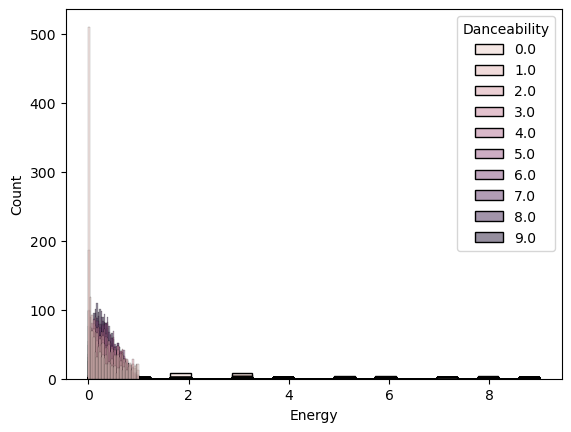

In [74]:
sns.histplot(data=f.orginDataset, x="Energy", hue="Danceability")
plt.show()

In [12]:
f.original['Energy']

0        0.000273
1        0.184220
2             NaN
3        0.209585
4             NaN
           ...   
17165    0.794023
17166    0.820026
17167    0.571787
17168    0.451218
17169    0.825294
Name: Energy, Length: 17170, dtype: float64

In [163]:
outputs = f.labels.unique()

In [22]:
t = DLModel(f.train, f.validate, f.test,  epoch = 100000, batch_size = 1024, learning_rate=2.6e-6)

In [211]:
t.trainModel(outputs)

Epoch ===> :   0%|          | 1/100000 [00:00<13:17:26,  2.09it/s, Epoch=0, validation_loss=32.8, Validation Acc=4.92, Step=3, from=4]


Training Stage ==> Epoch: 0 / 99999 | Training loss: 33.13607 |  Training Accuracy: 4.88562 | Training Metric (MAE): 4.88562
Validation Stage ==> Epoch: 0 / 99999 | Validation loss: 32.77778 |  Validation Accuracy: 4.91565 | Validation Metric (MAE)): 4.91565
Load Model from best epoch 0
Training Stage ==> Epoch: 1 / 99999 | Training loss: 32.98310 |  Training Accuracy: 4.89809 | Training Metric (MAE): 4.89809
Validation Stage ==> Epoch: 1 / 99999 | Validation loss: 32.77420 |  Validation Accuracy: 4.91529 | Validation Metric (MAE)): 4.91529
Load Model from best epoch 1
Training Stage ==> Epoch: 2 / 99999 | Training loss: 33.95529 |  Training Accuracy: 4.88692 | Training Metric (MAE): 4.88692
Validation Stage ==> Epoch: 2 / 99999 | Validation loss: 32.77062 |  Validation Accuracy: 4.91493 | Validation Metric (MAE)): 4.91493
Load Model from best epoch 2
Training Stage ==> Epoch: 3 / 99999 | Training loss: 34.24881 |  Training Accuracy: 4.89736 | Training Metric (MAE): 4.89736
Validation 

KeyboardInterrupt: 

In [36]:
t = DLModel(f.train, f.validate, f.testDATAFILE,  epoch = 100000, batch_size = 1024, learning_rate=2.6e-6, loadModelFlag = True, loadModelFile = './model/model_EPOCH_53915')

In [41]:
y, y_hat =t.testinfModel(t.test)

torch.Size([1024, 10]) torch.Size([1024, 19]) torch.Size([1024, 126])
torch.Size([1024, 10]) torch.Size([1024, 19]) torch.Size([1024, 126])
torch.Size([700, 10]) torch.Size([700, 19]) torch.Size([700, 126])
Loss: 8.30034 |  Validation Accuracy: 2.51979


In [42]:
y

array([7., 1., 8., ..., 8., 3., 3.], dtype=float32)

In [40]:
for i in y_hat:
    print(i)

4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
4.3832307
